In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as cp

from PIL import ImageFont, ImageDraw, Image
import glob
import os
from tqdm import tqdm
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

1.7.1 True
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
images = glob.glob("./imagefolder/images/*.jpg")
def get_mask_fname(fname):
    return os.path.join("./imagefolder/masks/",os.path.basename(fname))
get_mask_fname(images[1000])    

'./imagefolder/masks/3342.jpg'

In [3]:
def get_mask(fname):
    mask = cv2.imread(fname)
    im_bw = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    ret,thresh = cv2.threshold(im_bw,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)[-2:]
    x,y,w,h = cv2.boundingRect(contours[0])
    return [x,y,x+w,y+h]
def get_annotation_dict_from_mask(ims):

    dataset = []
    for idx,filename in enumerate(ims):
        record = {}
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        obj = {
                "bbox": get_mask(get_mask_fname(filename)),
                "bbox_mode": BoxMode.XYXY_ABS,
                # "segmentation": [poly],
                "category_id": 0,
            }
        objs.append(obj)

        record["annotations"] = objs
        dataset.append(record)
    return dataset



In [4]:
train_images = np.random.choice(images,1500,replace=False)
val_images = [im for im in images if im not in train_images]
len(val_images),len(train_images)

(523, 1500)

In [5]:
d="train"
DatasetCatalog.register("roadsignsv1_" + d, lambda d=d: get_annotation_dict_from_mask(train_images))
MetadataCatalog.get("roadsignsv1_" + d).set(thing_classes=["roadsigns"])
d="val"
DatasetCatalog.register("roadsignsv1_" + d, lambda d=d: get_annotation_dict_from_mask(val_images))
MetadataCatalog.get("roadsignsv1_" + d).set(thing_classes=["roadsigns"])
roadsign_metadata = MetadataCatalog.get("roadsignsv1_train")

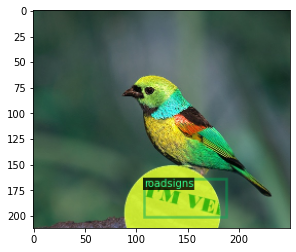

In [6]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
dataset_dicts = get_annotation_dict_from_mask(train_images)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "outputv1"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("roadsignsv1_train",)
cfg.DATASETS.TEST = ("roadsignsv1_val",)
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = "model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.TEST.EVAL_PERIOD = 100
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

time: 0.3252  data_time: 0.0012  lr: 0.000085  max_mem: 2733M
[01/04 08:36:55 d2.utils.events]:  eta: 0:06:11  iter: 359  total_loss: 0.584  loss_cls: 0.208  loss_box_reg: 0.324  loss_rpn_cls: 0.018  loss_rpn_loc: 0.009  time: 0.3235  data_time: 0.0011  lr: 0.000090  max_mem: 2733M
[01/04 08:37:01 d2.utils.events]:  eta: 0:06:05  iter: 379  total_loss: 0.600  loss_cls: 0.190  loss_box_reg: 0.377  loss_rpn_cls: 0.014  loss_rpn_loc: 0.007  time: 0.3236  data_time: 0.0012  lr: 0.000095  max_mem: 2733M
[01/04 08:37:21 d2.data.common]: Serializing 523 elements to byte tensors and concatenating them all ...
[01/04 08:37:21 d2.data.common]: Serialized dataset takes 0.11 MiB
[01/04 08:37:21 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
WARNING [01/04 08:37:21 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/04 08:37:2

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
cfg.DATASETS.TEST = ("boardetect_val", )
predictor = DefaultPredictor(cfg)

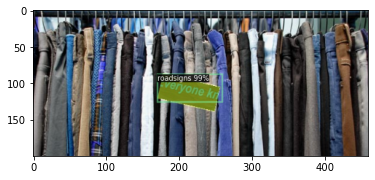

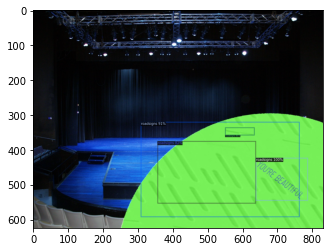

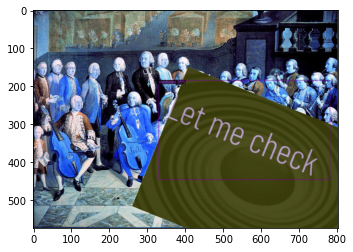

In [9]:
dataset_dicts = get_annotation_dict_from_mask(train_images)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=0.8)
    # out = visualizer.draw_dataset_dict(d)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

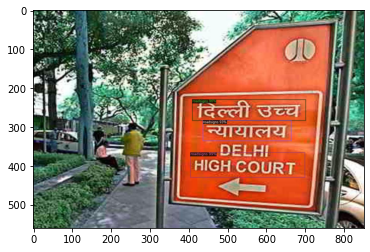

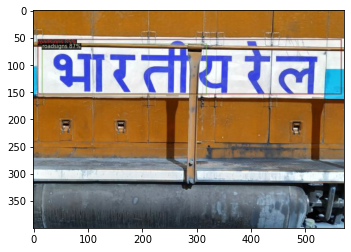

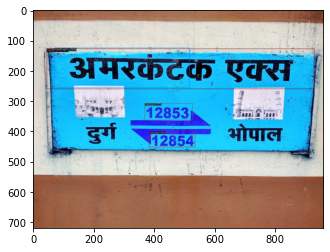

In [13]:
otherimgs = glob.glob("../input/Text Detection Dataset/Text Detection Dataset/Train/Images/*.jpeg")
for d in random.sample(otherimgs, 3):
    img = cv2.imread(d)
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=0.8)
    # out = visualizer.draw_dataset_dict(d)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

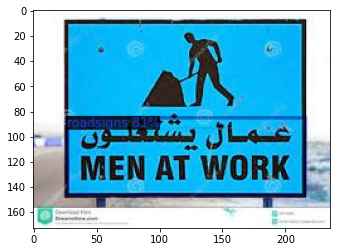

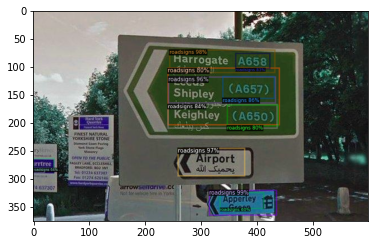

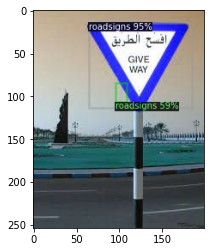

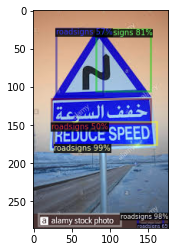

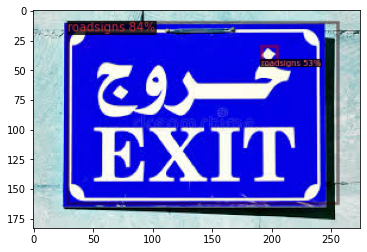

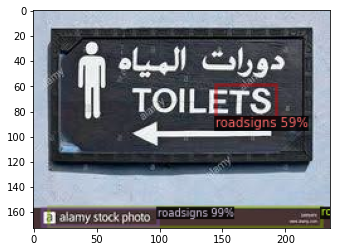

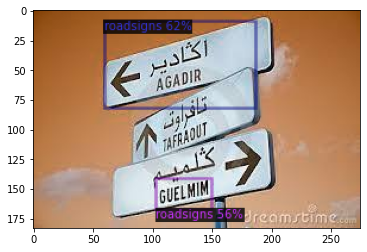

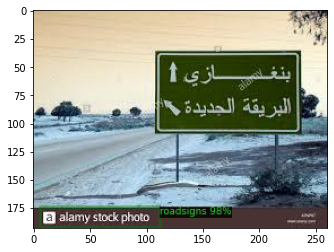

In [15]:
eval_images = glob.glob("../input/eval_oics/*.jpg")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
# cfg.DATASETS.TEST = ("boardetect_val", )
predictor = DefaultPredictor(cfg)
for d in eval_images:
    img = cv2.imread(d)
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=1)
    # out = visualizer.draw_dataset_dict(d)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

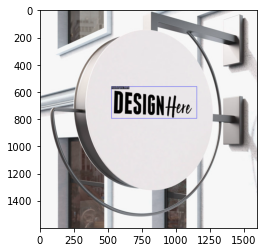

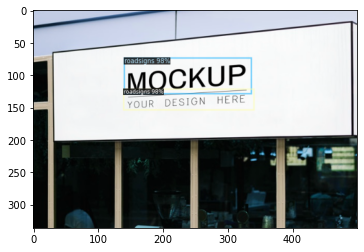

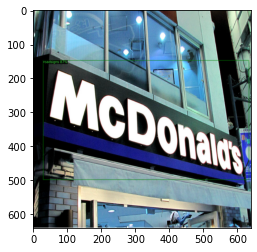

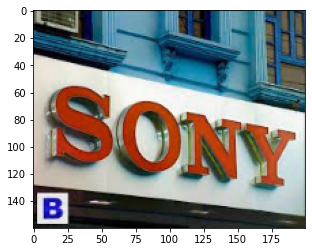

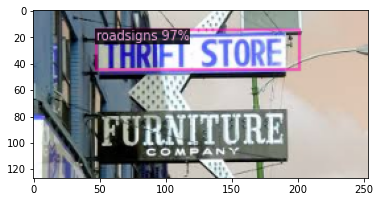

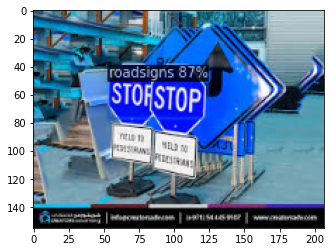

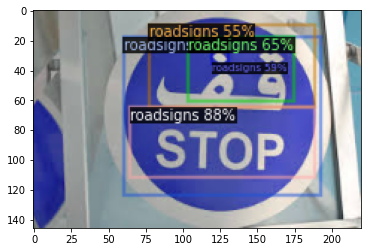

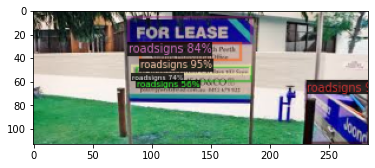

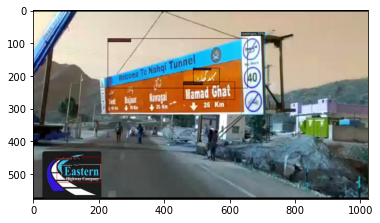

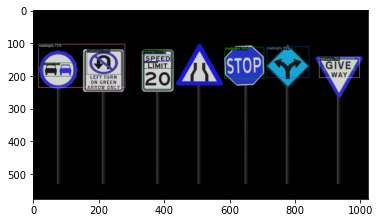

In [30]:
otherimgs = glob.glob("../input/eng_pics/*")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
for d in otherimgs:
    img = cv2.imread(d)
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=roadsign_metadata, scale=0.8)
    # out = visualizer.draw_dataset_dict(d)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()